In [1]:
import numpy as np
from skyfield.api import Topos, load, EarthSatellite
import datetime
import pytz
import matplotlib.pyplot as plt
from functools import lru_cache
import passpredict

In [2]:
# Topographic location
lat, lon, h = 30.2711, -97.7437, 0
austin = Topos(latitude=lat, longitude=lon, elevation_m=h)

In [3]:
# TLE for ISS
tle1 = "1 25544U 98067A   20154.57277630  .00016717  00000-0  10270-3 0  9118"
tle2 = "2 25544  51.6443  60.8122 0001995  12.6931 347.4269 15.49438452 29742"
satellite = EarthSatellite(tle1, tle2, "ISS")

In [4]:
# time period
datetime_start = datetime.datetime(2020, 6, 1, 0, 0, 0, tzinfo=pytz.utc)
datetime_end = datetime.datetime(2020, 6, 11, 0, 0, 0, tzinfo=pytz.utc)
seconds_between = int((datetime_end-datetime_start).total_seconds())
dt_seconds = 5
ts = load.timescale().utc(2020, 6, 1, 0, 0, np.arange(0,seconds_between, dt_seconds))  # skyfield timescale

In [5]:
rho = satellite - austin

In [6]:
satellite_position = satellite.at(ts)
# p2.itrf_xyz().km

In [7]:
skyfield_rECEF = np.array(satellite_position.itrf_xyz().km)
from passpredict.propagate import propagate
passpredict_rECEF = propagate(tle1, tle2, datetime_start, datetime_end, dt_seconds).rECEF

In [8]:
print(skyfield_rECEF.shape)
print(passpredict_rECEF.shape)
n = skyfield_rECEF.shape[1]

(3, 172800)
(3, 172800)


In [9]:
# Save skyfield data for later
# np.save('passpredict/tests/data/skyfield_iss_rECEF',skyfield_rECEF, allow_pickle=True, fix_imports=True)


In [10]:
diff = skyfield_rECEF - passpredict_rECEF
datetime_array = np.arange(datetime_start, datetime_end, np.timedelta64(dt_seconds, 's'))
print(datetime_array)

['2020-06-01T00:00:00.000000' '2020-06-01T00:00:05.000000'
 '2020-06-01T00:00:10.000000' ... '2020-06-10T23:59:45.000000'
 '2020-06-10T23:59:50.000000' '2020-06-10T23:59:55.000000']


In [11]:
x=np.linalg.norm(diff, axis=0)
diff.shape

(3, 172800)

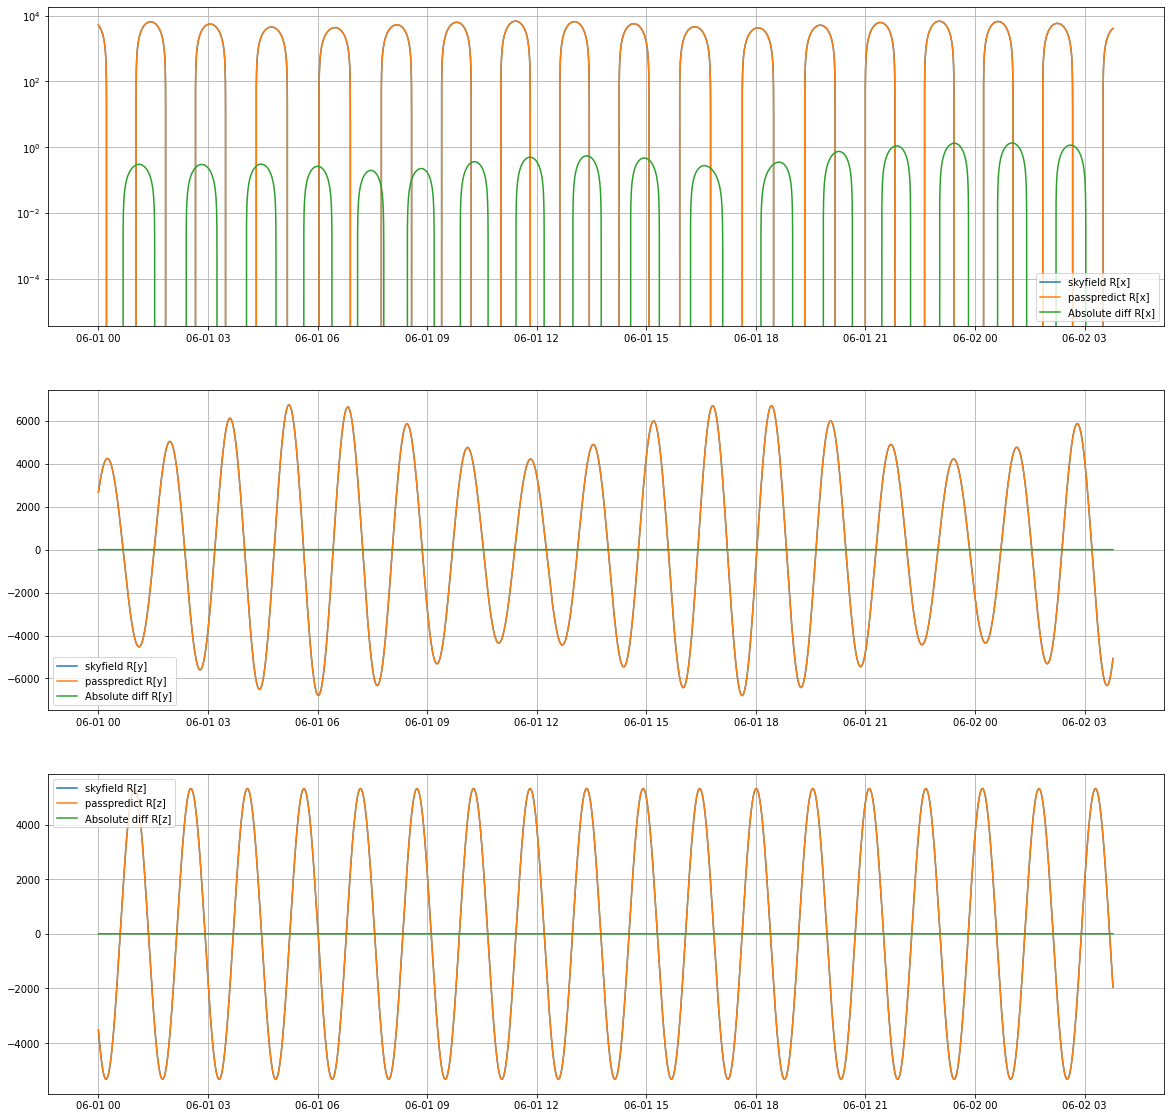

In [14]:
idx = np.arange(0, 20000, dtype=np.int32)
# idx = np.arange(0, n)
%matplotlib inline

fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(3,1, 1)
ax.plot(datetime_array[idx], skyfield_rECEF[0][idx], label='skyfield R[x]')
ax.plot(datetime_array[idx], passpredict_rECEF[0][idx], label='passpredict R[x]')
ax.plot(datetime_array[idx], skyfield_rECEF[0][idx]-passpredict_rECEF[0][idx], label='Absolute diff R[x]')
ax.legend()
ax.grid()

ax1 = fig.add_subplot(3,1,2)
ax1.plot(datetime_array[idx], skyfield_rECEF[1][idx], label='skyfield R[y]')
ax1.plot(datetime_array[idx], passpredict_rECEF[1][idx], label='passpredict R[y]')
ax1.plot(datetime_array[idx], skyfield_rECEF[1][idx]-passpredict_rECEF[1][idx], label='Absolute diff R[y]')
ax1.legend()
ax1.grid()

ax2 = fig.add_subplot(3,1,3)
ax2.plot(datetime_array[idx], skyfield_rECEF[2][idx], label='skyfield R[z]')
ax2.plot(datetime_array[idx], passpredict_rECEF[2][idx], label='passpredict R[z]')
ax2.plot(datetime_array[idx], skyfield_rECEF[2][idx]-passpredict_rECEF[2][idx], label='Absolute diff R[z]')
ax2.legend()
ax2.grid()

plt.show()